In [4]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [6]:
# Load the dataset
data = pd.read_csv('dataset.csv')

In [4]:
print(data.head())

   launch_speed  launch_angle         target
0          92.4         -13.0  Groundoutable
1         102.7           0.0  Groundoutable
2         103.3          23.0     Flyoutable
3          99.3           1.0         Single
4          94.5          58.0     Flyoutable


In [10]:
# Convert the 'target' column to 1-hot encoded vectors
data_one_hot = pd.get_dummies(data, columns=['target'])

# Rename the columns to "prob_<category>"
data_one_hot = data_one_hot.rename(columns=lambda col: f"prob_{col.split('_')[-1]}" if 'target_' in col else col)

# Convert the 1-hot encoded columns to floats (0.0 and 1.0)
data_one_hot = data_one_hot.astype(float)

# Display the first few rows to verify the result
print(data_one_hot.head())


   launch_speed  launch_angle  prob_Double  prob_Flyoutable  \
0          92.4         -13.0          0.0              0.0   
1         102.7           0.0          0.0              0.0   
2         103.3          23.0          0.0              1.0   
3          99.3           1.0          0.0              0.0   
4          94.5          58.0          0.0              1.0   

   prob_Groundoutable  prob_Homerun  prob_Lineoutable  prob_Single  \
0                 1.0           0.0               0.0          0.0   
1                 1.0           0.0               0.0          0.0   
2                 0.0           0.0               0.0          0.0   
3                 0.0           0.0               0.0          1.0   
4                 0.0           0.0               0.0          0.0   

   prob_Triple  
0          0.0  
1          0.0  
2          0.0  
3          0.0  
4          0.0  


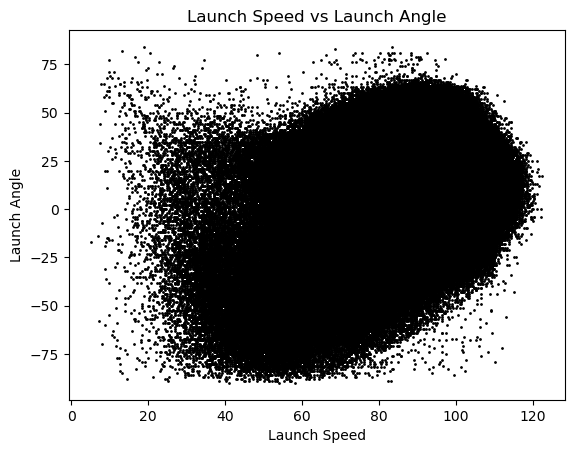

In [13]:
# Create a scatter plot
plt.scatter(data['launch_speed'], data['launch_angle'], color='black', s=1)
plt.title('Launch Speed vs Launch Angle')
plt.xlabel('Launch Speed')
plt.ylabel('Launch Angle')
plt.show()

In [16]:
# Print ranges for 'launch_speed' and 'launch_angle', and unique categories in 'target'
launch_speed_range = data['launch_speed'].min(), data['launch_speed'].max()
launch_angle_range = data['launch_angle'].min(), data['launch_angle'].max()
target_categories = data['target'].unique()

print(f"Launch Speed Range: {launch_speed_range}")
print(f"Launch Angle Range: {launch_angle_range}")
print(f"Target Categories: {target_categories}")

#### Notes
# We see that the values of Launch Angle are strictly integers

# From now on, we'll define the possible ranges to be:  
# Launch Speed Range: (5.0, 125.0)  
# Launch Angle Range: (-90.0, 85.0)
launch_speed_range = np.arange(5, 125, 0.1)  # Launch speed from 5 to 125, step 0.1
launch_angle_range = range(-90, 86, 1)  # Launch angle from -90 to 85, step 1

Launch Speed Range: (5.2, 122.4)
Launch Angle Range: (-90.0, 84.0)
Target Categories: ['Groundoutable' 'Flyoutable' 'Single' 'Double' 'Lineoutable' 'Homerun'
 'Triple']


In [3]:
# First, split the data into 90% train and 10% temp (temp will later be split into validation and test)
train_data, temp_data = train_test_split(data, test_size=0.1, random_state=42)

# Now, split the 10% temp data into validation and test sets (50% each of the 10%)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# Display the sizes of the splits
print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")

# Optionally, you can save them back to CSV files if you need to:
# train_data.to_csv('train_data.csv', index=False)
# val_data.to_csv('val_data.csv', index=False)
# test_data.to_csv('test_data.csv', index=False)

Training set size: 1003147
Validation set size: 55730
Test set size: 55731


In [ ]:
def train_knn(train_data, k, dist_launch_speed, dist_launch_angle):
    """
    Train knn and return the probability tensor.
    Assume train_data is sorted based on launch_speed then launch_angle
    Inputs:
        train_data: training data
        k: # nearest neighbors
        dist: defines search space
    Outputs:
        tensor:
    """
    # Generate all combinations of launch_speed and launch_angle
    # (launch_speed_range, launch_angle_range defined above)
    not_enough_k = list(itertools.product(launch_speed_range, launch_angle_range))

    # Sort train_data based on 'launch_speed' and then 'launch_angle'
    td_sorted = train_data.sort_values(by=['launch_speed', 'launch_angle'])

    while not_enough_k and k > 0:
        batch = [] # For Batch Merge

        # Iterate over the combinations
        for launch_speed, launch_angle in not_enough_k[:]:  

            # 1. Trim td_sorted within dist from launch_speed, and within dist from launch_angle
            speed_lower, speed_upper = launch_speed-dist_launch_speed, launch_speed+dist_launch_speed
            # Use searchsorted to slice the data frame by the bounds
            left_idx = td_sorted['launch_speed'].searchsorted(speed_lower, side='left')
            right_idx = td_sorted['launch_speed'].searchsorted(speed_upper, side='right')
            speed_subset = td_sorted.iloc[left_idx:right_idx]
            # Further filter the subset by launch_angle.
            td_trimmed = speed_subset[np.abs(speed_subset['launch_angle'] - launch_angle) <= dist_launch_angle]

            # 2. If number of points within the trim < k, do nothing
            if len(td_trimmed) < k:
                continue 
            
            # 3. If number of points within the trim >= k:
            #     - Remove (launch_speed, launch_angle) from list
            #     - Insert launch_speed, launch_angle, probabilities into batch
            #       (Assume probabilities is calculated by probabilistickNN(td_trimmed))
            else:
                not_enough_k.remove((launch_speed, launch_angle))
                pseudolabel = probabilistic_knn((launch_speed,launch_angle), td_trimmed, k)
                batch.append(pseudolabel) # Insert into temporary batch

        # If batch is empty, decrease k to prevent infinite loop
        if not batch:
            k -= 1
            if k <= 0:  # End while loop if k becomes invalid
                print("Terminating loop: k is less than or equal to 0.")
            
        # Batch Merge
        # (Make sure to keep train_data sorted based on 'launch_speed' and then 'launch_angle')
        else:
            batch_df = pd.DataFrame(batch)  # Convert batch to DataFrame
            train_data = pd.concat([train_data, batch_df]).sort_values(by=['launch_speed', 'launch_angle'])

In [ ]:
def main():
    # hyperparameters
    k = 10
    dist_launch_speed = 10 # IMPORTANT: Make sure dist >= k OR ELSE train_knn GETS STUCK
    dist_launch_angle = 10

    # Train data
    
main()
    


